# Tarea 5 - Extracción de Relaciones

- Martínez Ostoa Néstor Iván
- Minería de Textos
- IIMAS, UNAM

---

Utilizando el conjunto de historias clínicas, extraer las siguientes relaciones de las entidades anotadas: 

- Strength-Drug
- Form-Drug
- Dosage-Drug
- Duration-Drug
- Frequency-Drug
- Route-Drug
- ADE-Drug
- Reason-Drug
 

Para las siguientes actividades es recomendable hacer una selección de características, de tal forma que se obtenga un mejor resultado.



## Actividad 1

Crear un clasificador que determine si cada par de entidades tiene o no una relación. Evaluar en el conjunto de prueba, obtener Precisión, Recall y F1.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import os

from brat_parser import get_entities_relations_attributes_groups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn import metrics

In [5]:
def build_context(e1, e2, text):
    """
    e1 and e2: Brat Parser's Entity class
    """
    (e1_left, e1_right) = e1.span[0]
    (e2_left, e2_right) = e2.span[0]
    
    left_context = text[:e1_left].split()[-3:]
    right_context = text[e2_right:].split()[:3]
    mid_context = text[e1_right:e2_left].split()
    
    context = left_context + mid_context + right_context
    context = " ".join(context)
    
    return context

def search(relation, relations):
    left = 0
    right = len(relations)-1
    while (left <= right):
        mid = (left + right) // 2
        
        if (relations[mid] == relation):
            return mid
        
        elif (relations[mid][0] >= relation[0]):
            right = mid-1
        
        else:
            left = mid+1
    
    return -1

In [13]:
def process(path):
    X = []
    y = []
    R = [] # possible relations
    all_text = []
    num_relations = 0
    for (_,_,files) in os.walk(path):
        for file in files:
            if file[-3:] == "ann":
                text = ""
                with open(path + file[:-3] + "txt") as f:
                    for line in f: text += line
                
                all_text.append(text)
                entities, relations_v, _, _ = get_entities_relations_attributes_groups(path + file)
                
                sorted_entities = sorted(list(entities.values()), key=operator.attrgetter('span'))
                
                relations = list(relations_v.values())
                relations = [(int(r.subj[1:]), int(r.obj[1:])) for r in relations]
                relations = sorted(relations)
                
                num_relations += len(relations)
                
                for i in range(1, len(sorted_entities), 2):
                    e1 = sorted_entities[i-1]
                    e2 = sorted_entities[i]
                    
                    e1_id = int(e1.id[1:])
                    e2_id = int(e2.id[1:])
                    
                    c = build_context(e1, e2, text)
                    
                    if len(c) <= 150:
                        X.append(c)

                        rA = (e1_id, e2_id)
                        rB = (e2_id, e1_id)

                        rA_result = search(rA, relations)
                        rB_result = search(rB, relations)

                        if (rA_result == -1 and rB_result == -1):
                            y.append(0)
                            R.append('<NONE>')
                        else:
                            y.append(1)
                            found = rA_result if rA_result != -1 else rB_result
                            rf = relations[found]
                            for r in list(relations_v.values()):
                                subject_ = int(r.subj[1:])
                                object_ = int(r.obj[1:])
                                if ((subject_, object_) == rf or (object_, subject_) == rf):
                                    R.append(r.type)
                                    break
                    
    return pd.DataFrame({'context': X, 'relation': y, 'relation_name': R}), all_text, num_relations

In [14]:
training_df, training_text, training_num_relations = process('training/')
test_df, test_text, test_num_relations = process('test/')

In [8]:
print(training_num_relations, test_num_relations)

36348 23462


In [11]:
print(training_df.shape, '\n')
print(training_df['relation'].value_counts(), '\n')
print(training_df['relation_name'].value_counts(), '\n')
training_df.head()

(25398, 3) 

0    19539
1     5859
Name: relation, dtype: int64 

<NONE>            19539
Strength-Drug      3228
Reason-Drug         987
Route-Drug          520
Dosage-Drug         385
ADE-Drug            297
Form-Drug           190
Frequency-Drug      154
Duration-Drug        98
Name: relation_name, dtype: int64 



,context,relation,relation_name
0,and underwent an ; the patient only required o...,0,<NONE>
1,"1 unit of , of platelets, 500-cc",0,<NONE>
2,"2 units of , of albumin, and",0,<NONE>
3,"platelets, 500-cc of , and of cryo intraop.",0,<NONE>
4,1 unit of . He was taken to the APCU intubated...,0,<NONE>


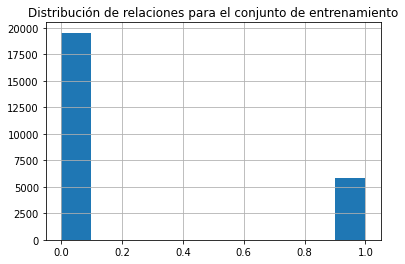

In [12]:
training_df['relation'].hist()
plt.title(f"Distribución de relaciones para el conjunto de entrenamiento")
plt.show()

In [158]:
print(test_df.shape, '\n')
print(test_df['relation'].value_counts(), '\n')
print(test_df['relation_name'].value_counts(), '\n')
test_df.head()

(15264, 3) 

0    11469
1     3795
Name: relation, dtype: int64 

<NONE>            11469
Strength-Drug      1997
Reason-Drug         665
Route-Drug          308
Dosage-Drug         235
ADE-Drug            227
Form-Drug           157
Frequency-Drug      124
Duration-Drug        82
Name: relation_name, dtype: int64 



,context,relation,relation_name
0,Service: MEDICINE Allergies: / Attending:[**Do...,0,<NONE>
1,She spiked a approx 5 hours after presentation...,0,<NONE>
2,1 gram of and became afebrile. She initially r...,0,<NONE>
3,recieved 1 L . Her (per verbal signout),0,<NONE>
4,started on peripheral and additional NS were g...,0,<NONE>


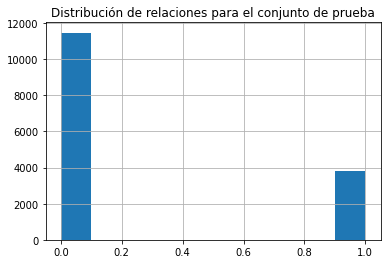

In [159]:
test_df['relation'].hist()
plt.title(f"Distribución de relaciones para el conjunto de prueba")
plt.show()

In [160]:
vect_bow = CountVectorizer(binary=True)
vect_bow.fit_transform(training_text)

<303x18539 sparse matrix of type '<class 'numpy.int64'>'
	with 228431 stored elements in Compressed Sparse Row format>

In [161]:
X_train = vect_bow.transform(training_df['context'].values)
y_train = training_df['relation']
X_test = vect_bow.transform(test_df['context'].values)
y_test = test_df['relation']

In [162]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (23645, 18539)
y_train: (23645,)
X_test: (15264, 18539)
y_test: (15264,)


In [163]:
svc = SVC(tol=1e-5, C=3.0)
svc.fit(X_train, y_train)

SVC(C=3.0, tol=1e-05)

In [164]:
y_pred = svc.predict(X_test)

In [203]:
print(metrics.classification_report(
    y_test, y_pred, digits=4
))

              precision    recall  f1-score   support

           0     0.8678    0.9259    0.8959     11469
           1     0.7193    0.5739    0.6384      3795

    accuracy                         0.8384     15264
   macro avg     0.7936    0.7499    0.7672     15264
weighted avg     0.8309    0.8384    0.8319     15264



## Actividad 2

Crear un clasificador que determine el tipo de relación tienen las entidades. Se puede utilizar el clasificador de la actividad 1 para filtrar las parejas de entidades que no tienen relación. Evaluar en el conjunto de prueba, obtener Precisión, Recall y F1.

In [188]:
training_filtered_df = training_df[training_df['relation'] != 0]
test_filtered_df = test_df[test_df['relation'] != 0]
training_filtered_df.head()

,context,relation,relation_name
6,consistent with a . He was started on a . One day,1,Reason-Drug
11,[**2185-7-13**] by urology. was started on [**...,1,Duration-Drug
12,[**7-24**]). # Acute : Patient previously on ....,1,Reason-Drug
13,for infarction. Increased from po to 2mg,1,Strength-Drug
16,[**2185-7-13**]. Further increased from po to 4mg,1,Strength-Drug


In [169]:
vect_filtered_bow = CountVectorizer(binary=True)
vect_filtered_bow.fit_transform(training_text)

<303x18539 sparse matrix of type '<class 'numpy.int64'>'
	with 228431 stored elements in Compressed Sparse Row format>

In [191]:
relations_dict = {}
rels_names = training_filtered_df['relation_name'].unique()
for i, r in enumerate(rels_names):
    relations_dict[r] = i
relations_dict

{'Reason-Drug': 0,
 'Duration-Drug': 1,
 'Strength-Drug': 2,
 'Form-Drug': 3,
 'Dosage-Drug': 4,
 'ADE-Drug': 5,
 'Route-Drug': 6,
 'Frequency-Drug': 7}

In [192]:
def change_name(relation):
    return relations_dict[relation]

In [194]:
training_filtered_df['relation_name'] = training_filtered_df['relation_name'].apply(change_name)
training_filtered_df

<ipython-input-194-e8f007ad5504>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_filtered_df['relation_name'] = training_filtered_df['relation_name'].apply(change_name)


,context,relation,relation_name
6,consistent with a . He was started on a . One day,1,0
11,[**2185-7-13**] by urology. was started on [**...,1,1
12,[**7-24**]). # Acute : Patient previously on ....,1,0
13,for infarction. Increased from po to 2mg,1,2
16,[**2185-7-13**]. Further increased from po to 4mg,1,2
...,...,...,...
23626,"carbonate 200 mg ( ) Tablet, Chewable",1,2
23633,DAILY (Daily). 12. Cream [**Month/Year (2),1,2
23637,TUBE* Refills:*3* 13. Lotion [**Month/Year (2),1,2
23641,Medications: ?????? Take (enteric coated) once,1,2


In [195]:
test_filtered_df['relation_name'] = test_filtered_df['relation_name'].apply(change_name)
test_filtered_df

<ipython-input-195-743662639990>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered_df['relation_name'] = test_filtered_df['relation_name'].apply(change_name)


,context,relation,relation_name
8,"vancomycin, 500 mg , 750 mg",1,6
11,2 grams of . . On,1,6
13,a pulse and dose of (completed on [**2125-9-2*...,1,4
18,as rifamixin. . : Likely pre-renal. Resolved w...,1,0
21,was dicharged on daily and lovenox,1,2
...,...,...,...
15229,"was transfused another of to keep plt>75,",1,4
15231,one week of for in setting of,1,0
15250,a day). 5. Patch 24HR Sig:,1,2
15258,Tablet(s)* Refills:*0* 7. Tablet Sig: One,1,2


In [196]:
X_fil_train = vect_filtered_bow.transform(training_filtered_df['context'].values)
y_fil_train = training_filtered_df['relation_name']

X_fil_test = vect_filtered_bow.transform(test_filtered_df['context'].values)
y_fil_test = test_filtered_df['relation_name']

In [198]:
print(f"X_train: {X_fil_train.shape}")
print(f"y_train: {y_fil_train.shape}")

print(f"X_test: {X_fil_test.shape}")
print(f"y_test: {y_fil_test.shape}")

X_train: (5778, 18539)
y_train: (5778,)
X_test: (3795, 18539)
y_test: (3795,)


In [199]:
svc = SVC(tol=1e-5, C=3.0)
svc.fit(X_fil_train, y_fil_train)

SVC(C=3.0, tol=1e-05)

In [200]:
y_fil_pred = svc.predict(X_fil_test)

In [202]:
print(metrics.classification_report(
    y_fil_test, y_fil_pred, digits=4, target_names=list(relations_dict.keys())
))

                precision    recall  f1-score   support

   Reason-Drug     0.6053    0.7955    0.6875       665
 Duration-Drug     0.6296    0.2073    0.3119        82
 Strength-Drug     0.8334    0.9469    0.8865      1997
     Form-Drug     0.8000    0.1274    0.2198       157
   Dosage-Drug     0.4071    0.2426    0.3040       235
      ADE-Drug     0.7949    0.4097    0.5407       227
    Route-Drug     0.4041    0.4448    0.4235       308
Frequency-Drug     0.5000    0.0161    0.0312       124

      accuracy                         0.7236      3795
     macro avg     0.6218    0.3988    0.4256      3795
  weighted avg     0.7132    0.7236    0.6894      3795



## Actividad 3

Discutir los resultados.

---

- Para ambos clasificadores (binario y multivariado), utilicé el modelo bag-of-words, sin realizar un preprocesamiento exhausitivo de los datos de entrada. Podemos observar que los resultados para el claisficador binario (f1 score= 0.8319) es mejor que el clasificador multivariado (0.6894) puesto que naturalmente es más sencillo realizar clasificaciones sobre 2 clases que 9

- Adicionalmente, si incluimos otro tipo de técnicas más avanzadas para la generación del corpus de entrenamiento y prueba, como por ejemplo, un árbol de dependencias, seguramente veremos incrementos en los valores F1

- Por otro lado, también se pueden realizar mejoras en el preprocesamiento de los datos:
    - Como por ejemplo, tratar de segmentar de mejor forma las oraciones, porque en el modelo actual, el contexto se forma por medio de 3 tokens previo a la entidad 1, 3 tokens posterioes a la entidad 2 y todos los tokens intermedios entre ambas entidades. Sin embargo, existen casos en donde las entidades 1 y 2 pertenecen a oraciones distintas y eso es algo que no se está considerando actualmente